In [1]:
# imports
import os 
import sys
sys.path.append('../../')

# import custom reinforcement library
import reinforcement_library as reinlib

# import cartpole + pytorch online q-learner
arch = reinlib.python_policy_gradient.python_autograd_arch_designer
plotter = reinlib.visualization_tools.history_plotter

# load in autoreload so any changes made to backend files mirrored in notebook
# without the need to restart kernel
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
# imports
import gym
from autograd import numpy as np
import copy
import pickle

class PG():
    # load in simulator, initialize global variables
    def __init__(self,simulator,savename,**kwargs):
        # make simulator global
        self.simulator = gym.make('CartPole-v1') 
        
        # Q learn params
        self.explore_val = 1
        self.explore_decay = 0.99
        self.num_episodes = 500        
        self.gamma = 1
        
        if "gamma" in kwargs:   
            self.gamma = kwargs['gamma']
        if 'explore_val' in kwargs:
            self.explore_val = kwargs['explore_val']
        if 'explore_decay' in kwargs:
            self.explore_decay = kwargs['explore_decay']
        if 'num_episodes' in kwargs:
            self.num_episodes = kwargs['num_episodes']
            
        # other training variables
        self.num_actions = self.simulator.action_space.n
        state = self.simulator.reset()    
        self.state_dim = np.size(state)
        self.training_reward = []
        
        # setup memory params
        self.memory_length = 10     # length of memory replay (in episodes)
        self.episode_update = 1     # when to update (in episodes)
        self.memory = []
        if 'memory_length' in kwargs:
            self.memory_length = kwargs['memory_length']
        if 'episode_update' in kwargs:
            self.episode_update = kwargs['episode_update']
            
        ### initialize logs ###
        # create text file for training log
        self.logname = 'training_logs/' + savename + '.txt'
        self.reward_logname = 'reward_logs/' + savename + '.txt'
        self.weight_name = 'saved_model_weights/' + savename + '.pkl' 
        self.model_name = 'models/' + savename + '.json'

        self.init_log(self.logname)
        self.init_log(self.reward_logname)
        self.init_log(self.weight_name)
        self.init_log(self.model_name)
     
    ##### logging functions #####
    def init_log(self,logname):
        # delete log if old version exists
        if os.path.exists(logname): 
            os.remove(logname)
            
    def update_log(self,logname,update):
        if type(update) == str:
            logfile = open(logname, "a")
            logfile.write(update)
            logfile.close() 
        else:
            weights = []
            if os.path.exists(logname):
                with open(logname,'rb') as rfp: 
                    weights = pickle.load(rfp)
            weights.append(update)

            with open(logname,'wb') as wfp:
                pickle.dump(weights, wfp)
    
    ##### functions for creating / updating Q #####
    def initialize_Q(self,**kwargs):
        # default parameters for network
        layer_sizes = [10,10]      # two hidden layers, 10 units each, by default
        activation = 'relu'
        if 'layer_sizes' in kwargs:
            layer_sizes = kwargs['layer_sizes']
        if 'activation' in kwargs:
            activation = kwargs['activation']

        # default parameters for optimizer - reset by hand
        self.lr = 10**(-2)
        if 'alpha' in kwargs:
            self.lr = kwargs['alpha']

        # input / output sizes of network
        input_dim = self.state_dim
        output_dim = self.num_actions
        layer_sizes.insert(0,input_dim)    
        layer_sizes.append(output_dim)

        # setup architecture, choose cost, and setup architecture
        self.model = arch.super_setup.Setup()
        self.model.choose_cost(name = 'multiclass_softmax')
        self.model.choose_features(layer_sizes = layer_sizes,activation = activation)
            
        # initialize Q
        self.Q = self.model.predict

    # compute long term rewards for weighted gradient descent steps
    def create_weights(self,episode_data):
        # create long term reward simulator
        rewards = []
        for j in range(len(episode_data)):
            sample = episode_data[j]
            reward = sample[3]
            rewards.append(reward/10)

        # build long term rewards for each step
        beta = np.zeros_like(np.array(rewards))
        longterm_reward = 0
        for t in reversed(range(len(rewards))):
            longterm_reward = rewards[t] + self.gamma*longterm_reward
            beta[t] = longterm_reward
        return beta
    
    # update control law function
    def update_control(self):
        # generate q_values based on most recent Q
        a_vals = []
        states = []
        for i in range(len(self.memory)):    
            # get episode_data
            episode_data = self.memory[i]
            
            # create long-term rewards (weights for gradient descent step)
            long_term_rewards = self.create_weights(episode_data)
            
            # create input/output data for gradient descent step
            s_in = []
            a_vals = []
            for j in range(len(episode_data)):
                # get next sample of episode
                sample = episode_data[j]
                state = sample[0]
                action = sample[2]
                
                # strip sample for parts
                s_in.append(state.T)
                a_vals.append(action)

            # convert lists to numpy arrays for descent step
            s_in = np.array(s_in).T
            s_in = s_in[0,:,:]
            a_vals = np.array(a_vals)[np.newaxis,:]
            beta = np.array(long_term_rewards)[np.newaxis,:]

            # take weighted descent step
            self.model.fit(s_in,a_vals,beta,algo = 'RMSprop',max_its = 1,alpha = self.lr,verbose = False)
        
        # update Q based on regressor updates
        self.Q = self.model.predict
        
    ##### functions for adjusting replay memory #####
    # update memory - add sample to list, remove oldest samples 
    def update_memory(self,episode_data):
        # add most recent trial data to memory
        self.memory.append(episode_data)

        # clip memory if it gets too long    
        num_episodes = len(self.memory)
        if num_episodes >= self.memory_length:    
            num_delete = num_episodes - self.memory_length
            self.memory[:num_delete] = []
    
    ##### Q Learning functionality #####
    # state normalizer
    def state_normalizer(self,states):
        states = np.array(states)[np.newaxis,:]
        return states
    
    # choose next action
    def choose_action(self,state):
        # pick action at random
        p = np.random.rand(1)   
        action = np.random.randint(self.num_actions)
            
        # pick action based on exploiting
        qs = self.Q(state.T) 
        if p > self.explore_val:
            action = np.argmax(qs)
        return action

    # special function to check done
    def check_done(self,done,reward):
        if done == True:
            reward = -100
        return done,reward
    
    # main training function
    def train(self,**kwargs):        
        ### start main PG loop ###
        for n in range(self.num_episodes): 
            # pick this episode's starting position - randomly initialize from f_system
            state = self.simulator.reset()    
            state = self.state_normalizer(state)
            total_episode_reward = 0
            done = False
            
            # get out exploit parameter for this episode
            if self.explore_val > 0.01:
                self.explore_val *= self.explore_decay
                    
            # run episode
            step = 0
            episode_data = []
            while done == False and step < 500:    
                # choose next action
                action = self.choose_action(state)
    
                # transition to next state, get associated reward
                next_state,reward,done,info = self.simulator.step(action)  
                next_state = self.state_normalizer(next_state)
                
                # store data for transition after episode ends
                episode_data.append([state,next_state,action,reward,done])

                # update total reward from this episode
                total_episode_reward+=reward
                state = copy.deepcopy(next_state)
                step+=1
            
            # update memory with this episode's data
            self.update_memory(episode_data)
            
            # update Q function
            if np.mod(n,self.episode_update) == 0:
                self.update_control()  
                  
            # print out update 
            update = 'training episode ' + str(n+1) +  ' of ' + str(self.num_episodes) + ' complete, ' +  ' explore val = ' + str(np.round(self.explore_val,3)) + ', episode reward = ' + str(np.round(total_episode_reward,2)) 

            self.update_log(self.logname,update + '\n')
            if np.mod(n+1,100)==0:
                print (update)

            update = str(total_episode_reward) + '\n'
            self.update_log(self.reward_logname,update)

            ### store this episode's computation time and training reward history
            self.training_reward.append(total_episode_reward)

            # save latest weights from this episode 
            update = self.model.weight_history[-1]
            self.update_log(self.weight_name,update)
            
        ### save weights ###
        update = 'q-learning algorithm complete'
        self.update_log(self.logname,update + '\n')
        print (update)

# Run test

In [3]:
# feed in current directory name and savename = experiment name
dirname = os.getcwd()
savename = 'cartpole_experiment_1'

# initialize PG Learn process
num_episodes = 1000
explore_decay = 0.995
explore_val = 1
gamma = 0.99

# initialize memory
episode_update = 1
memory_length = 10

# load into instance of learner
demo = PG(dirname,savename,num_episodes=num_episodes,explore_decay=explore_decay,explore_val=explore_val,memory_length=memory_length,episode_update=episode_update,gamma=gamma)

# initialize Q function
layer_sizes = [100]
alpha = 10**(-1)
activation = 'relu'
demo.initialize_Q(layer_sizes=layer_sizes,alpha=alpha,activation=activation)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [4]:
demo.train()

training episode 100 of 1000 complete,  explore val = 0.606, episode reward = 35.0
training episode 200 of 1000 complete,  explore val = 0.367, episode reward = 49.0
training episode 300 of 1000 complete,  explore val = 0.222, episode reward = 190.0
training episode 400 of 1000 complete,  explore val = 0.135, episode reward = 100.0
training episode 500 of 1000 complete,  explore val = 0.082, episode reward = 63.0
training episode 600 of 1000 complete,  explore val = 0.049, episode reward = 121.0
training episode 700 of 1000 complete,  explore val = 0.03, episode reward = 120.0
training episode 800 of 1000 complete,  explore val = 0.018, episode reward = 133.0
training episode 900 of 1000 complete,  explore val = 0.011, episode reward = 95.0
training episode 1000 of 1000 complete,  explore val = 0.01, episode reward = 144.0
q-learning algorithm complete


# plot total episode reward history

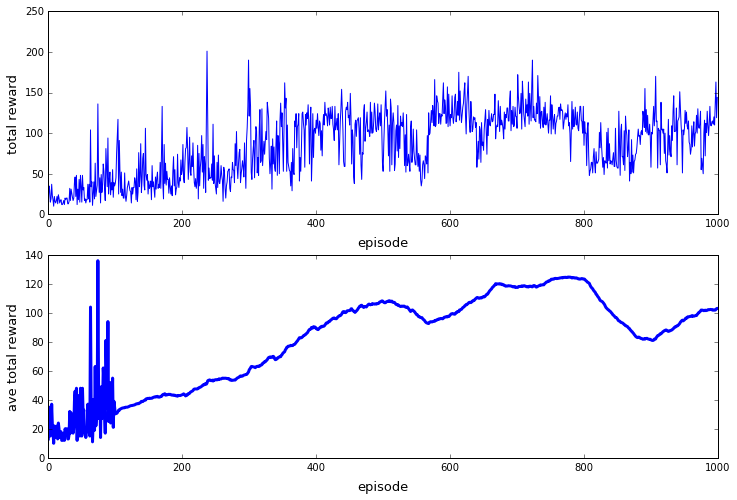

In [5]:
reward_logname = 'reward_logs/' + savename + '.txt'
plotter.plot_reward_history(reward_logname)